In [3]:
import pandas as pd
import os
import cv2
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm
import tensorflow_hub as hub
from tensorflow.keras.callbacks import Callback


ModuleNotFoundError: No module named 'tensorflow_hub'

In [ ]:
# Laad de handmatige annotaties
annotations = pd.read_csv('Data/input/annotaties_handmatig.csv')

def load_annotated_images(annotations):
    images = []
    labels = []
    for index, row in annotations.iterrows():
        image_path = os.path.join('Data/input/images_resized_annotated', row['image_name'])
        image = cv2.imread(image_path)
        bbox = [row['bbox_x'], row['bbox_y'], row['bbox_x'] + row['bbox_width'], row['bbox_y'] + row['bbox_height']]
        images.append(image)
        labels.append(bbox)
    return images, labels

annotated_images, labels = load_annotated_images(annotations)

In [ ]:
def prepare_data(images, labels):
    dataset = []
    for image, label in zip(images, labels):
        height, width, _ = image.shape
        normalized_label = [label[0] / width, label[1] / height, label[2] / width, label[3] / height]
        dataset.append((image, normalized_label))
    return dataset

train_data = prepare_data(annotated_images, labels)


In [ ]:
# Configure the model
pipeline_config = "4.3_FasterRCNN.config"
checkpoint_path = "path_to_pretrained_checkpoint/checkpoint"
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model = model_builder.build(model_config=model_config, is_training=True)

# Load the checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=model)
ckpt.restore(checkpoint_path).expect_partial()

@tf.function
def train_step(image_tensors, groundtruth_boxes_list):
    with tf.GradientTape() as tape:
        # Run the model, get the predictions
        preprocessed_images = tf.concat(image_tensors, axis=0)
        groundtruth_boxes = tf.concat(groundtruth_boxes_list, axis=0)
        groundtruth_classes = tf.ones_like(groundtruth_boxes[:, :, :1])  # Assuming class 1 for 'Insect'
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes,
            groundtruth_classes_list=groundtruth_classes
        )
        detections = model(preprocessed_images)
        losses_dict = model.loss(detections, true_image_shapes=None)
        total_loss = losses_dict['Loss/total_loss']
        
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
class TQDMProgressCallback(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.tqdm = tqdm(total=self.epochs, desc='Training Progress')
        
    def on_epoch_end(self, epoch, logs=None):
        self.tqdm.update(1)
        self.tqdm.set_postfix({
            'loss': logs['loss']
        })
        
    def on_train_end(self, logs=None):
        self.tqdm.close()

progress_callback = TQDMProgressCallback()

for epoch in range(10):  # Number of epochs
    for image, label in train_data:
        image_tensor = tf.convert_to_tensor(np.expand_dims(image, axis=0), dtype=tf.float32)
        groundtruth_boxes = tf.convert_to_tensor(np.expand_dims(label, axis=0), dtype=tf.float32)
        loss = train_step([image_tensor], [groundtruth_boxes])
        print(f"Epoch {epoch + 1}, Loss: {loss.numpy()}")

# Save the model
ckpt.save('4.3_FasterRCNN_Model.ckpt')


In [ ]:
def calculate_uncertainty(predictions):
    uncertainties = np.std(predictions['detection_boxes'], axis=1)
    return uncertainties

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50

2/2 [==============================] - 17s 517ms/step - loss: 6039.4512
Epoch 2/50
2/2 [==============================] - 1s 423ms/step - loss: 5223.1177
Epoch 3/50
2/2 [==============================] - 1s 441ms/step - loss: 4512.9443
Epoch 4/50
2/2 [==============================] - 1s 401ms/step - loss: 3821.4858
Epoch 5/50
2/2 [==============================] - 1s 418ms/step - loss: 3176.3992
Epoch 6/50
2/2 [==============================] - 1s 398ms/step - loss: 2600.8940
Epoch 7/50
2/2 [==============================] - 1s 403ms/step - loss: 2034.1298
Epoch 8/50
2/2 [==============================] - 1s 391ms/step - loss: 1538.4050
Epoch 9/50
2/2 [==============================] - 1s 393ms/step - loss: 1154.2955
Epoch 10/50
2/2 [==============================] - 1s 409ms/step - loss: 809.3011
Epoch 11/50
2/2 [==============================] - 1s 395ms/step - loss: 581.4726
Epoch 12/50
2/2 [==============================] - 1s 398ms/step - loss: 385.7379
Epoch 13/50
2/

c:\Users\Gebruiker\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def predict_and_select_uncertain(model, image_folder, num_samples=10):
    images = []
    image_paths = []
    for image_file in os.listdir(image_folder):
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path)
        images.append(image)
        image_paths.append(image_path)
    
    uncertainties = []
    for image in images:
        input_tensor = tf.convert_to_tensor(np.expand_dims(image, axis=0), dtype=tf.float32)
        detections = model(input_tensor)
        uncertainty = calculate_uncertainty(detections)
        uncertainties.append(uncertainty)
    
    uncertain_indices = np.argsort(-np.array(uncertainties))[:num_samples]
    uncertain_images = [image_paths[i] for i in uncertain_indices]
    
    return uncertain_images

# Selecteer de meest onzekere afbeeldingen
uncertain_images = predict_and_select_uncertain(model, 'Data/input/images_resized')

1233/1233 [==============================] - 168s 135ms/step


In [ ]:
# Bekijk de meest onzekere afbeeldingen
uncertain_images

['Data/input/images_resized\\182_20200726234634_37036.jpg',
 'Data/input/images_resized\\174_20200714001020_32444.jpg',
 'Data/input/images_resized\\281_20210815001431_14103.jpg',
 'Data/input/images_resized\\182_20200702235925_38508.jpg',
 'Data/input/images_resized\\248_20210809020044_41184.jpg',
 'Data/input/images_resized\\126_20200626015721_4975.jpg',
 'Data/input/images_resized\\274_20210901230045_4297.jpg',
 'Data/input/images_resized\\274_20210902013923_14555.jpg',
 'Data/input/images_resized\\192_20200726235214_15577.jpg',
 'Data/input/images_resized\\263_20210823235354_29195.jpg']

In [ ]:
# Laad het opgeslagen model
ckpt.restore('4.3_FasterRCNN_Model.ckpt').expect_partial()

# Dataset Annoteren met Model

In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
from keras.models import load_model
from tqdm.notebook import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
def predict_and_annotate(model, image_folder, input_shape, num_samples=100):
    annotations = []
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')][:num_samples]
    
    for image_file in tqdm(image_files, desc="Annotating Images", leave=True):
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path)
        resized_image = cv2.resize(image, (input_shape[1], input_shape[0]))
        input_image = np.expand_dims(resized_image, axis=0)
        
        # Onderdrukken van Keras logging
        tf.get_logger().setLevel('ERROR')
        
        # Voorspelling maken
        prediction = model.predict(input_image, verbose=0)[0]
        
        # Annotaties opslaan
        annotation = {
            'label_name': 'Insect',
            'bbox_x': int(prediction[0]),
            'bbox_y': int(prediction[1]),
            'bbox_width': int(prediction[2] - prediction[0]),
            'bbox_height': int(prediction[3] - prediction[1]),
            'image_name': image_file,
            'image_width': image.shape[1],
            'image_height': image.shape[0]
        }
        annotations.append(annotation)
    
    return annotations

# Voorspellingen maken en annotaties genereren
input_shape = (128, 128, 3)  # Zorg ervoor dat dit overeenkomt met de input shape van het model
annotations = predict_and_annotate(model, 'Data/input/images_resized', input_shape, num_samples=100)


Annotating Images:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Sla de annotaties op in een CSV-bestand
annotations_df = pd.DataFrame(annotations)
annotations_df.to_csv('4.2_annotaties_gegenereerd_SSD.csv', index=False)

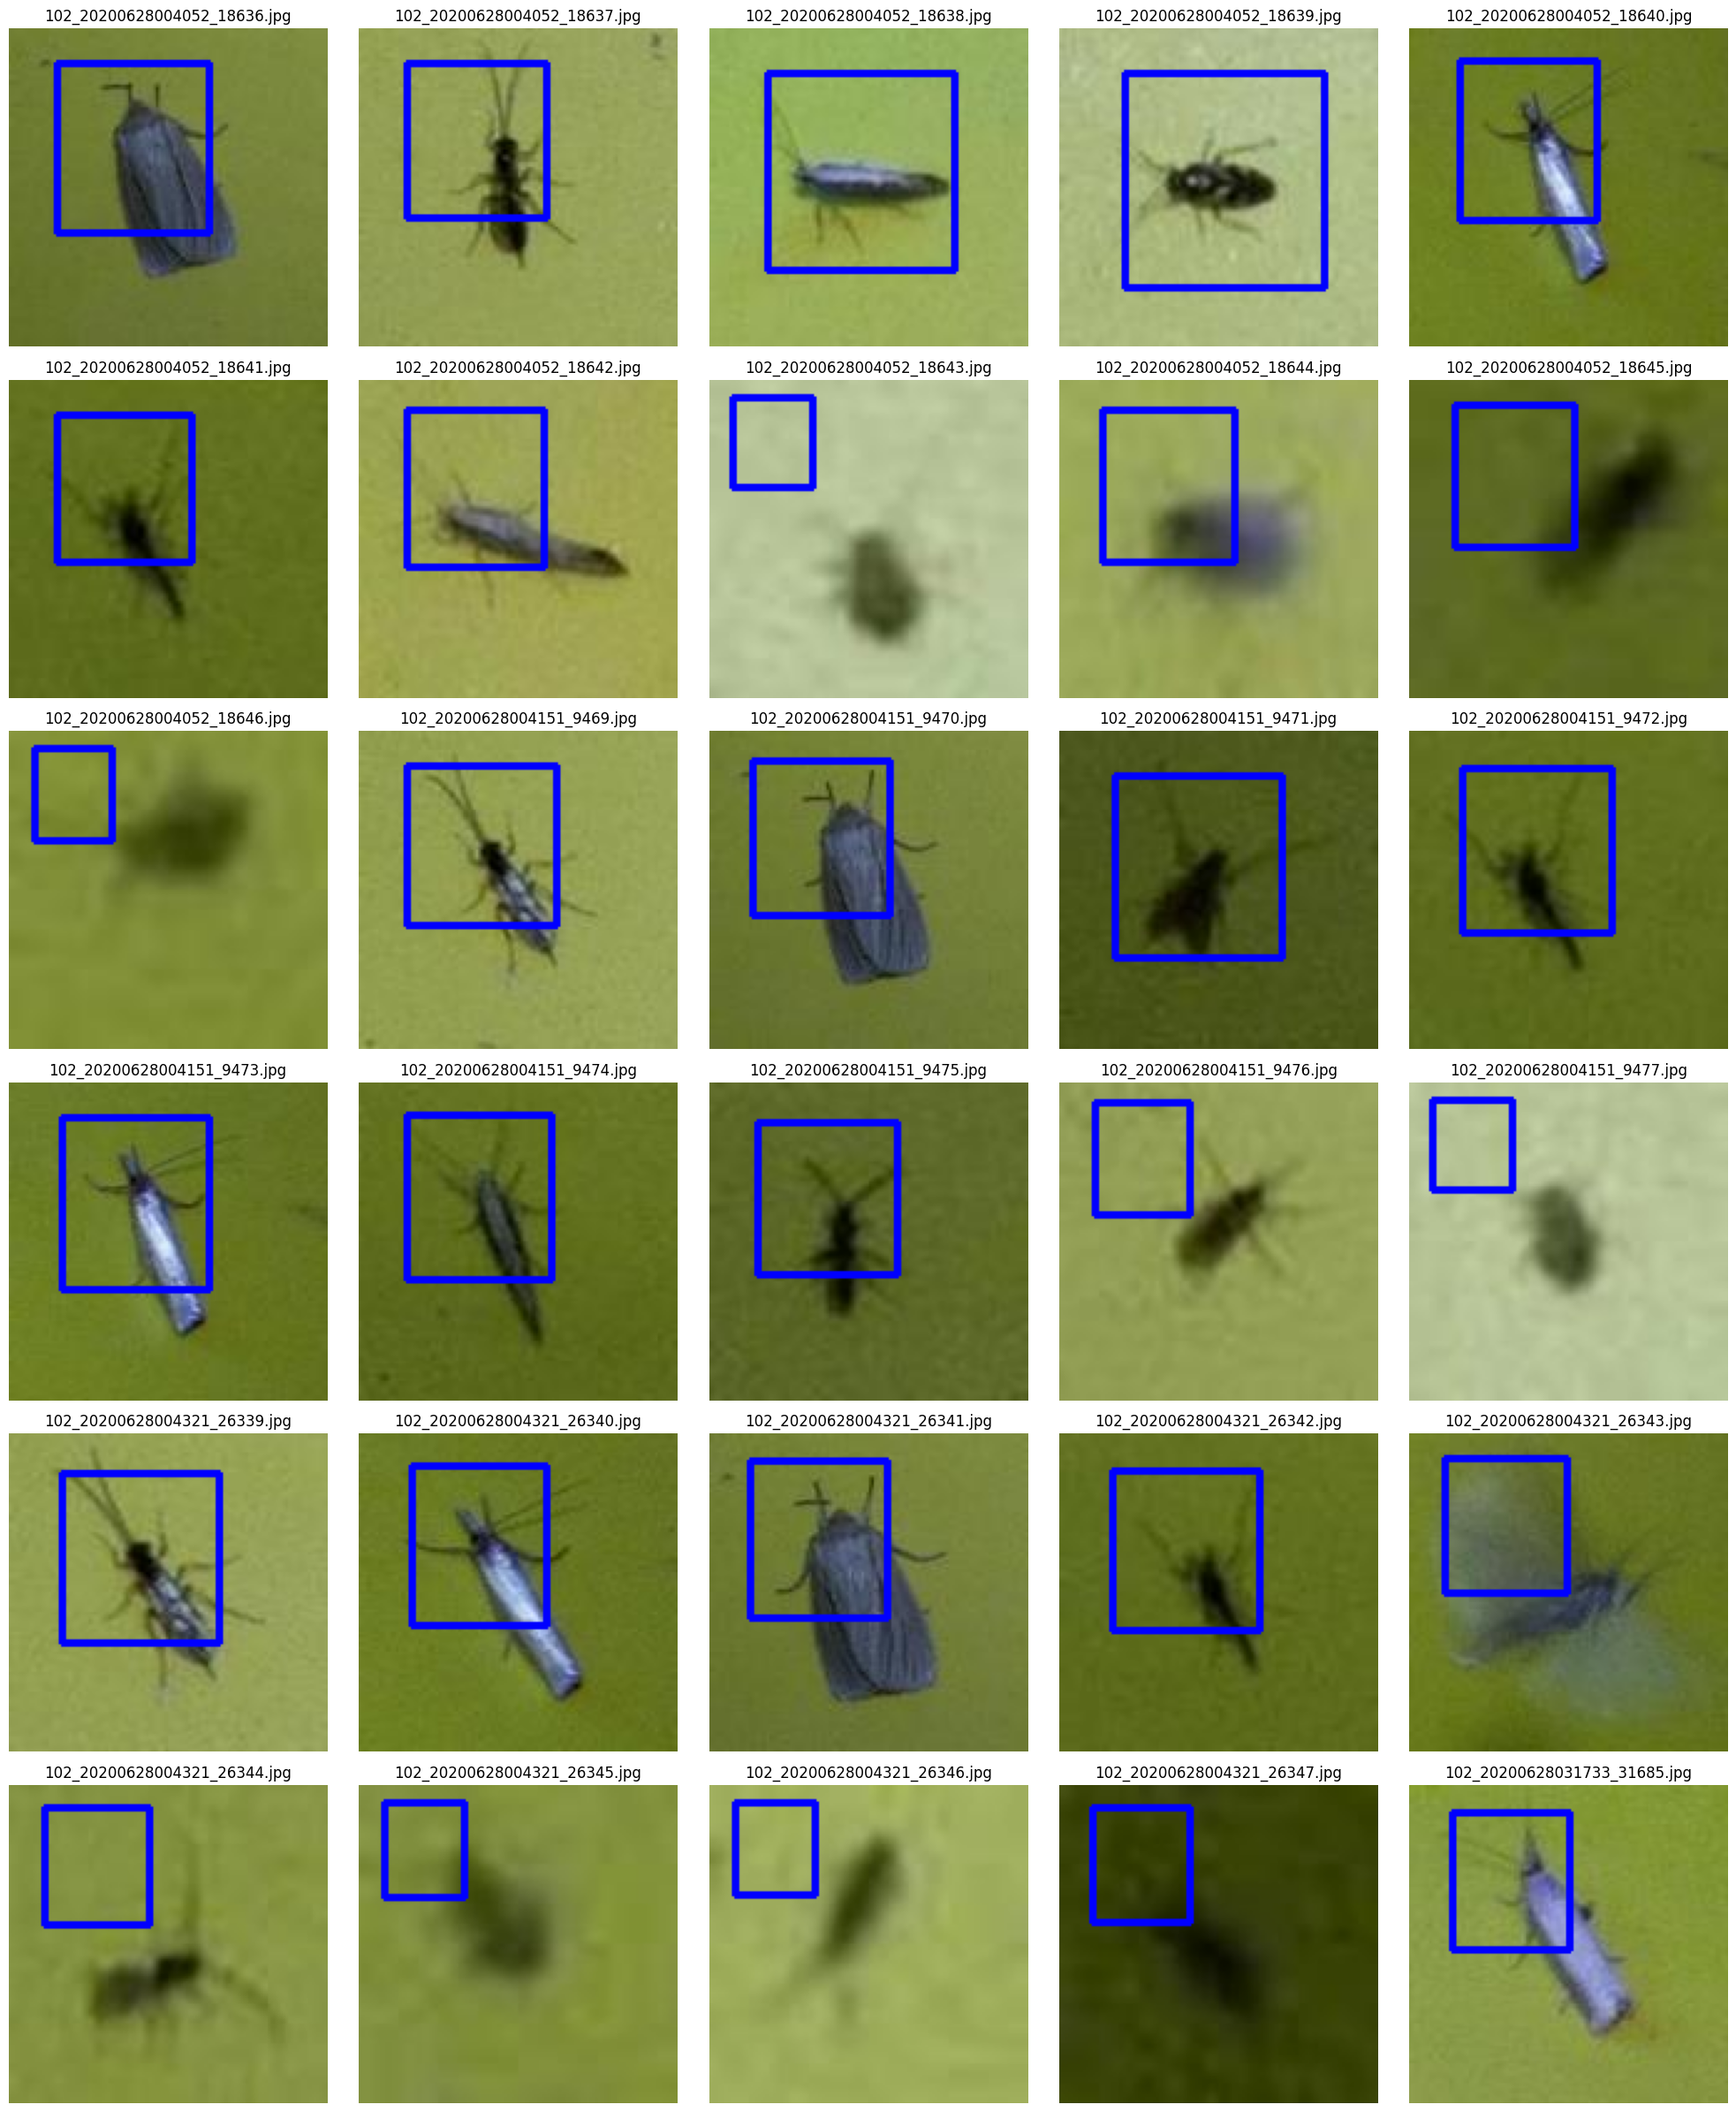

In [ ]:
def visualize_annotations(image_folder, annotations, num_images=30):
    # Laad een aantal afbeeldingen en hun annotaties
    sample_annotations = annotations.head(num_images)
    
    rows = num_images // 5
    fig, axes = plt.subplots(rows, 5, figsize=(20, 4 * rows))
    axes = axes.flatten()
    for ax, (_, row) in zip(axes, sample_annotations.iterrows()):
        image_path = os.path.join(image_folder, row['image_name'])
        image = cv2.imread(image_path)
        bbox_x, bbox_y = row['bbox_x'], row['bbox_y']
        bbox_width, bbox_height = row['bbox_width'], row['bbox_height']
        
        # Teken de bounding box
        start_point = (bbox_x, bbox_y)
        end_point = (bbox_x + bbox_width, bbox_y + bbox_height)
        color = (255, 0, 0)  # Rood
        thickness = 2
        image = cv2.rectangle(image, start_point, end_point, color, thickness)
        
        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ax.imshow(image)
        ax.set_title(row['image_name'])
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualiseer de geannoteerde afbeeldingen
visualize_annotations('Data/input/images_resized', annotations_df, num_images=30)
